# Lag Selection: domain knowledge
Conda environment: `time-series`  
17 Mar 2024

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [3]:
filename = "../datasets/AirQualityUCI_ready.csv"
data = pd.read_csv(filename, parse_dates=["Date_Time"], index_col=["Date_Time"])

data.sort_index(inplace=True)
data.head()

CO_true  CO_sensor  NMHC_true  C6H6_true  NMHC_sensor  \
Date_Time                                                                    
2004-03-10 18:00:00   2.6000 1,360.0000   150.0000    11.9000   1,046.0000   
2004-03-10 19:00:00   2.0000 1,292.0000   112.0000     9.4000     955.0000   
2004-03-10 20:00:00   2.2000 1,402.0000    88.0000     9.0000     939.0000   
2004-03-10 21:00:00   2.2000 1,376.0000    80.0000     9.2000     948.0000   
2004-03-10 22:00:00   1.6000 1,272.0000    51.0000     6.5000     836.0000   

                     NOX_true  NOX_sensor  NO2_true  NO2_sensor  O3_sensor  \
Date_Time                                                                    
2004-03-10 18:00:00  166.0000  1,056.0000  113.0000  1,692.0000 1,268.0000   
2004-03-10 19:00:00  103.0000  1,174.0000   92.0000  1,559.0000   972.0000   
2004-03-10 20:00:00  131.0000  1,140.0000  114.0000  1,555.0000 1,074.0000   
2004-03-10 21:00:00  172.0000  1,092.0000  122.0000  1,584.0000 1,203.0000   
2004-03-10 22:00:00  131.0000  1,205.0000  116.0000  1,490.0000 1,110.0000   

                          T      RH     AH  
Date_Time                                   
2004-03-10 18:00:00 13.6000 48.9000 0.7578  
2004-03-10 19:00:00 13.3000 47.7000 0.7255  
2004-03-10 20:00:00 11.9000 54.0000 0.7502  
2004-03-10 21:00:00 11.0000 60.0000 0.7867  
2004-03-10 22:00:00 11.2000 59.6000 0.7888

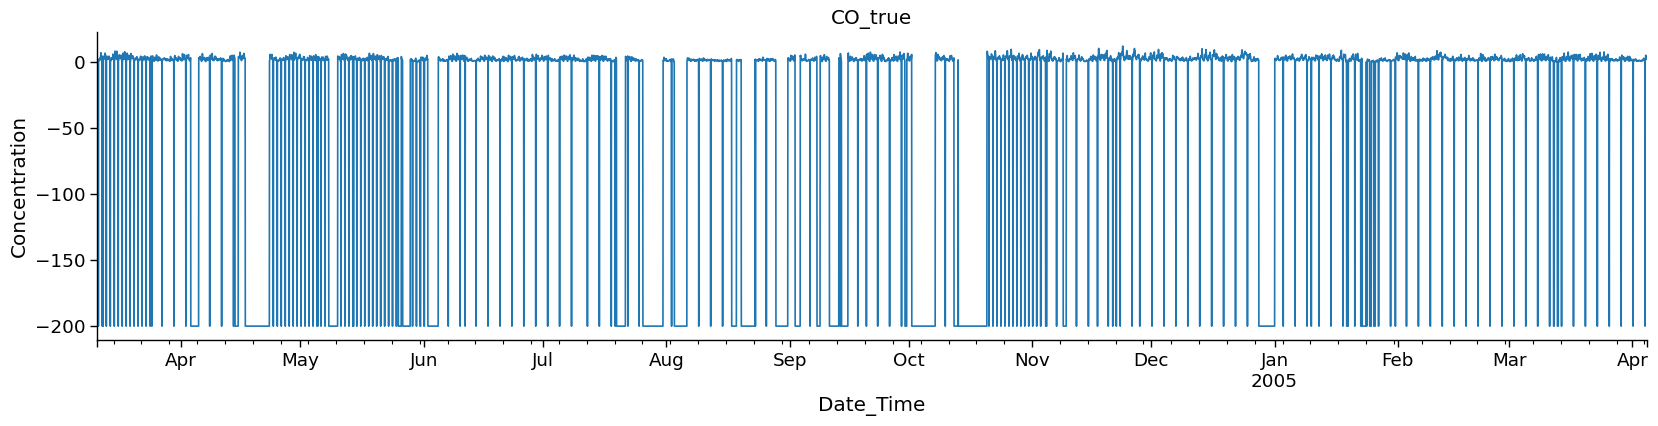

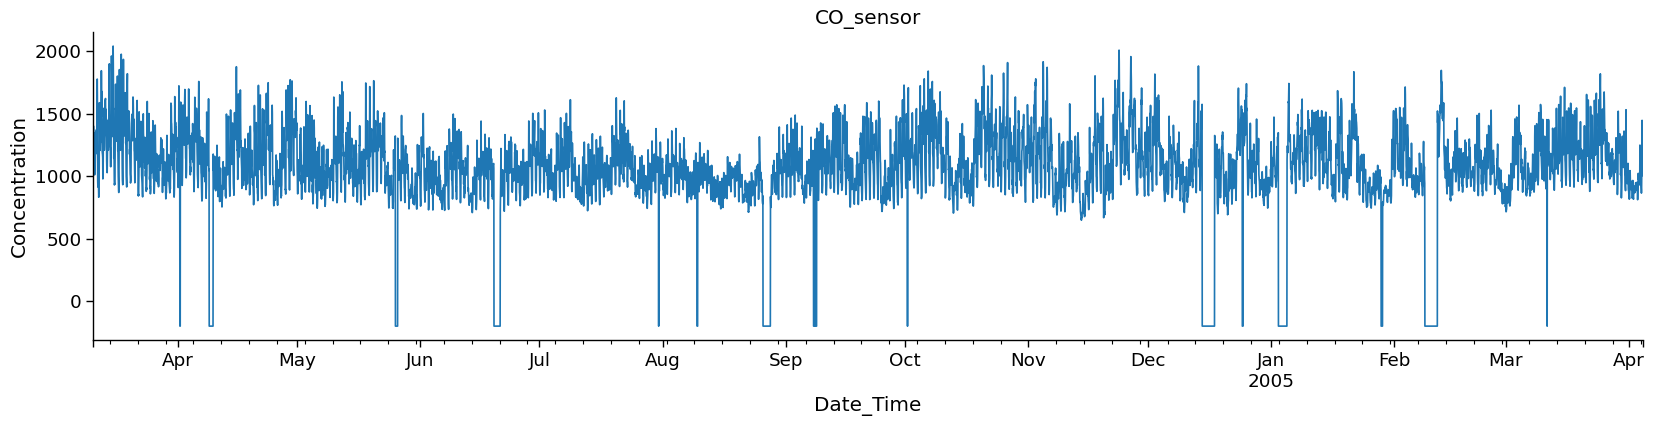

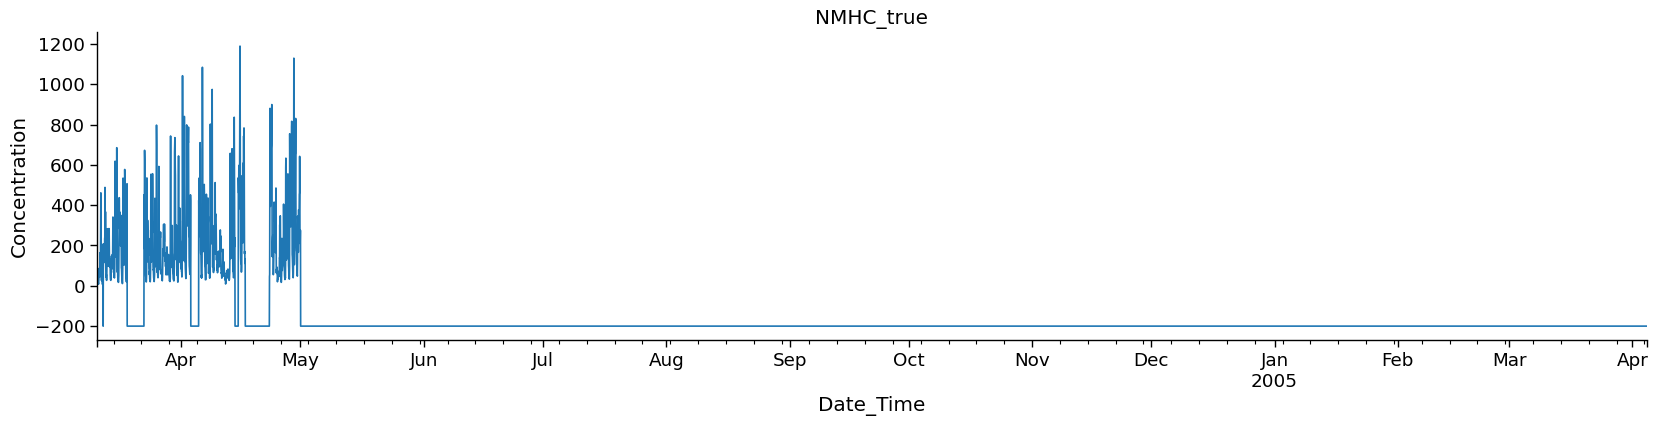

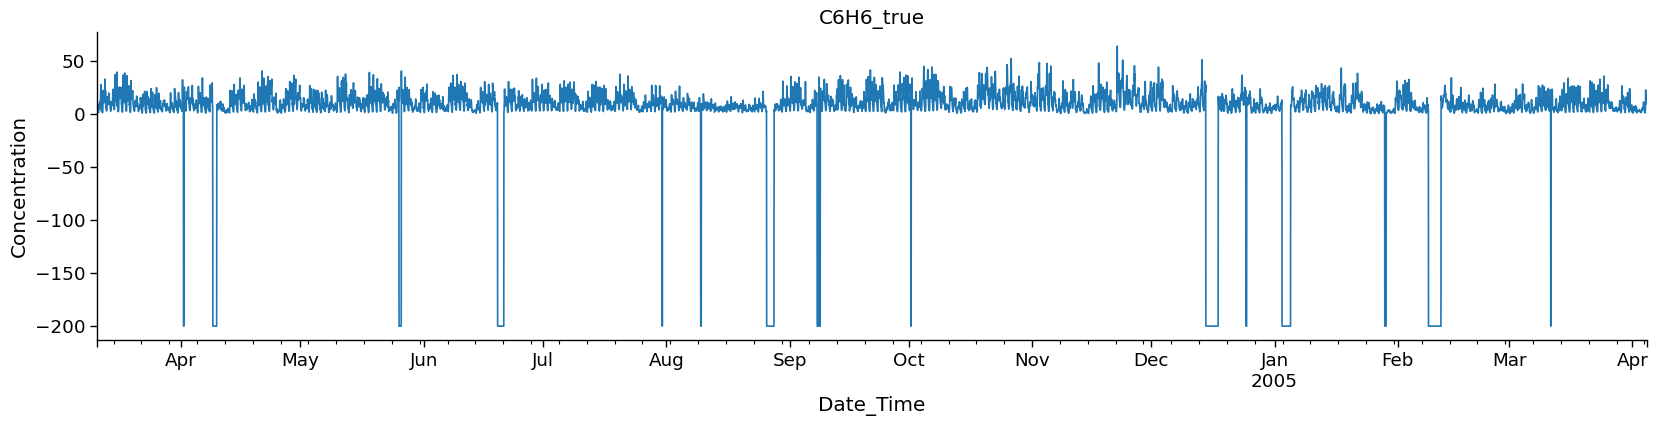

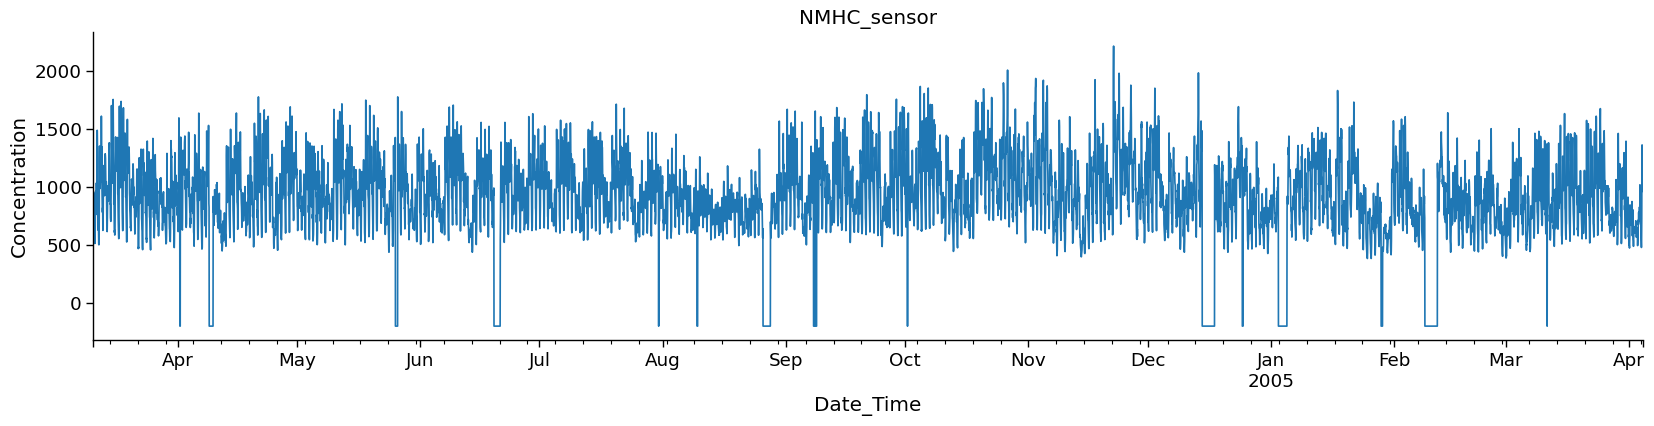

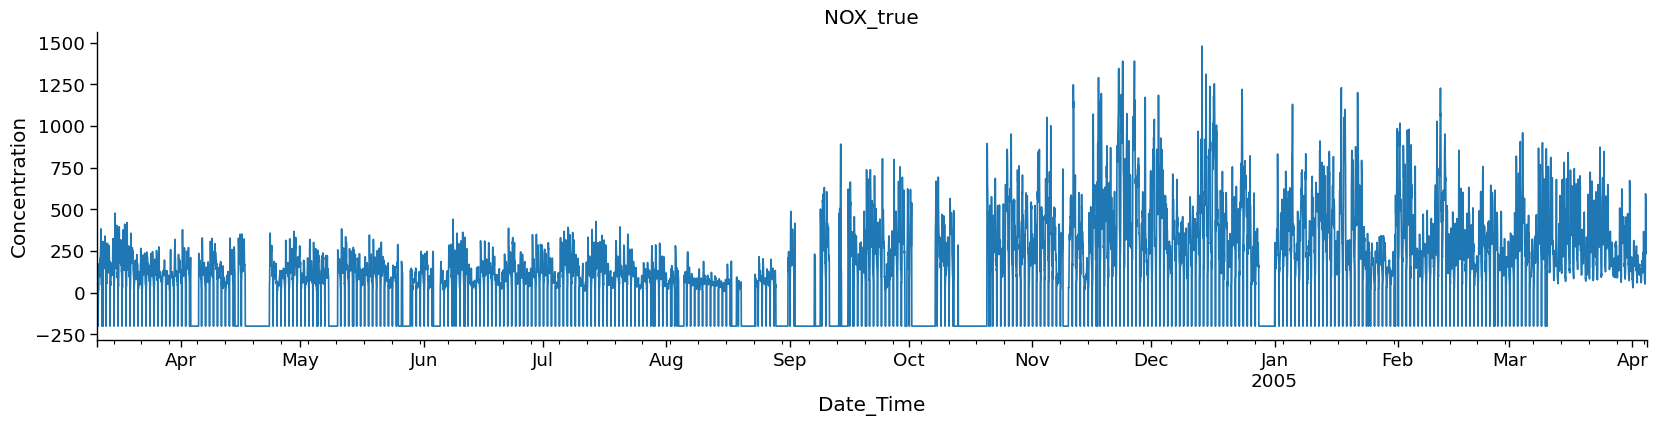

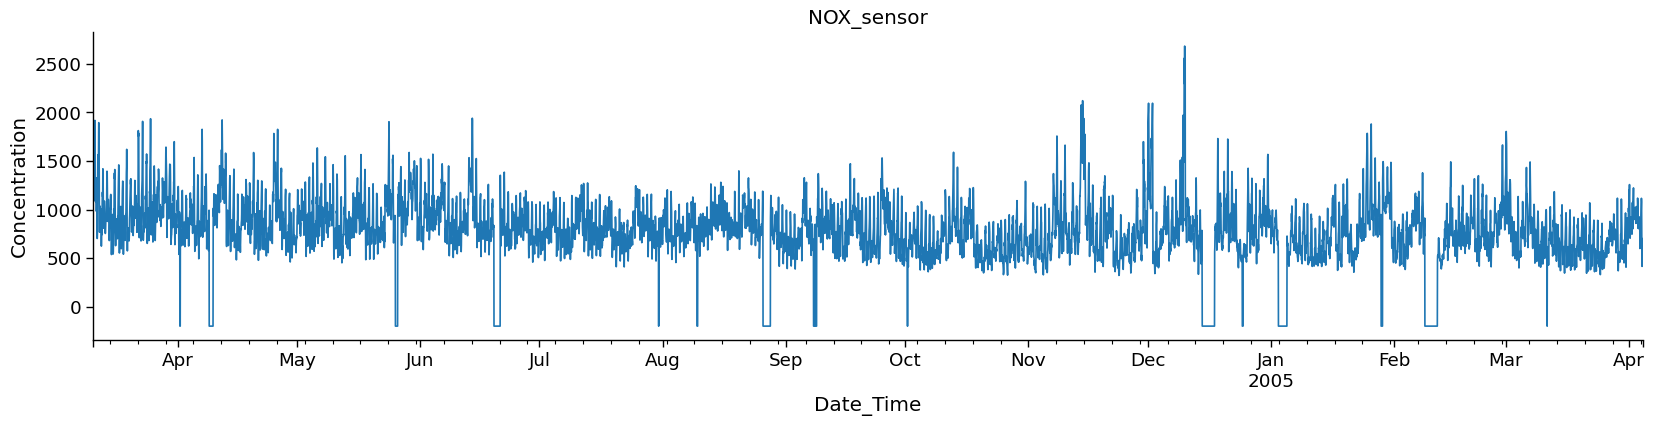

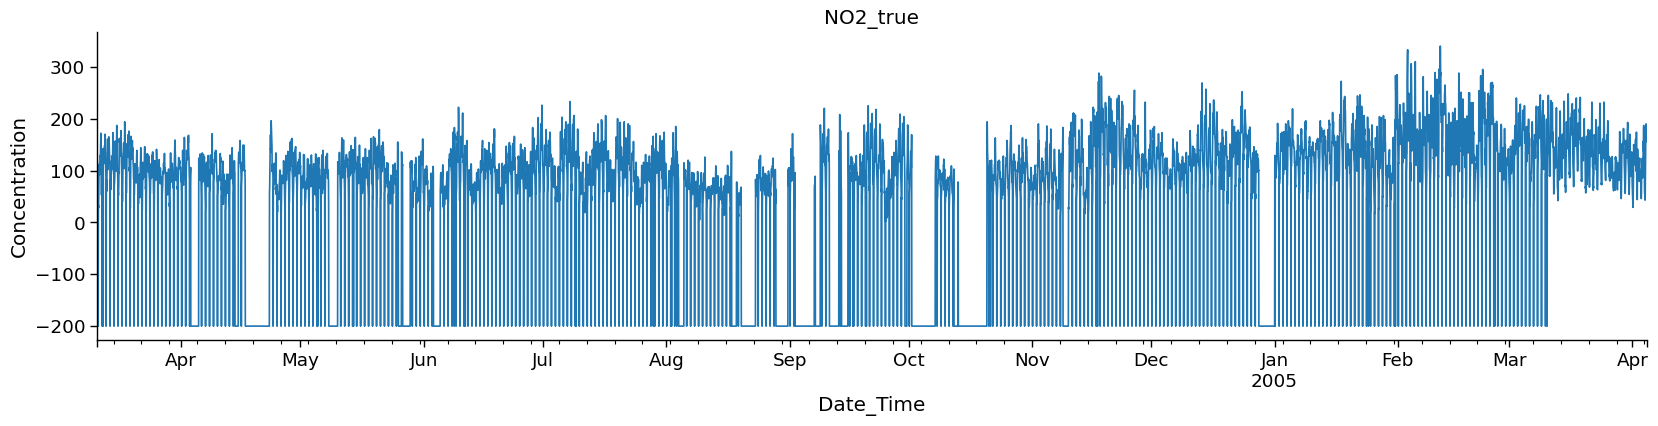

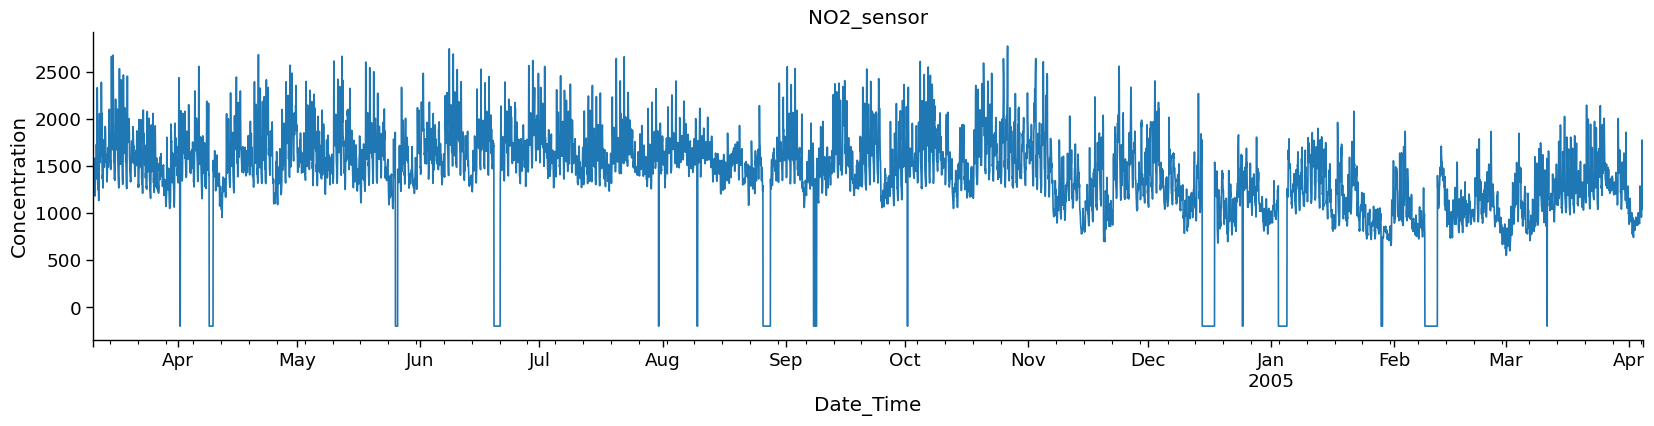

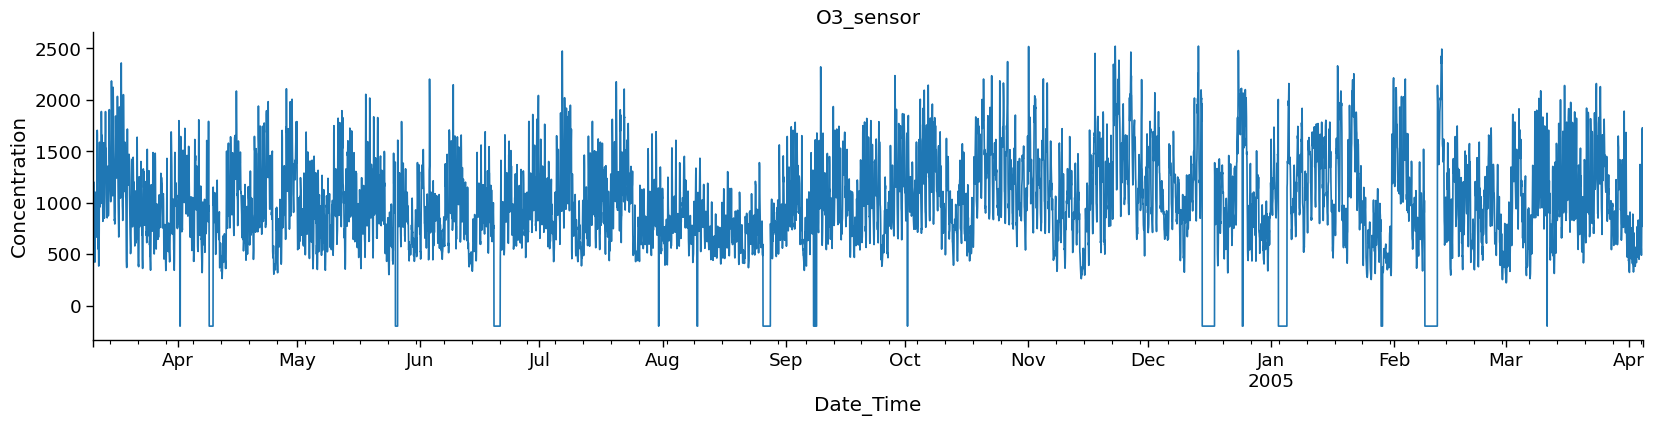

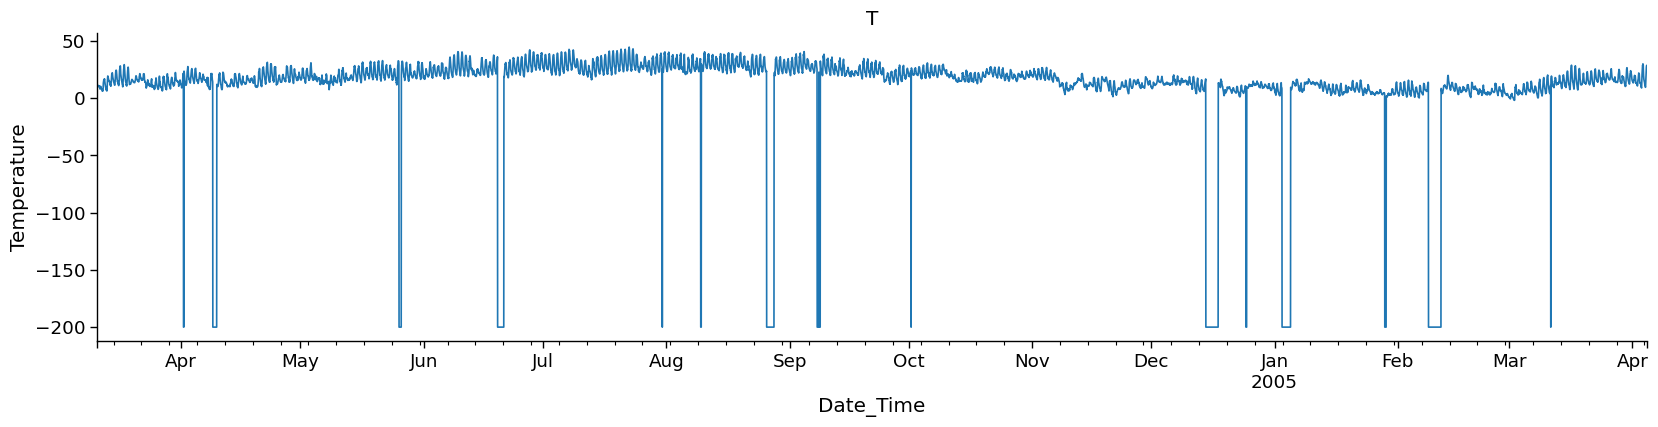

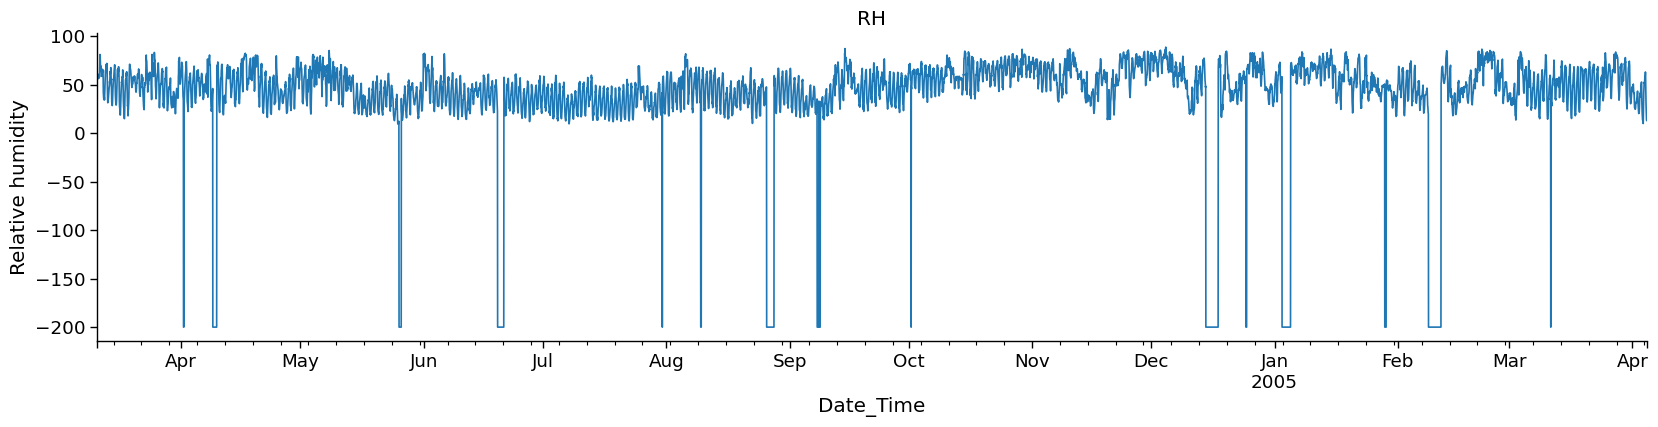

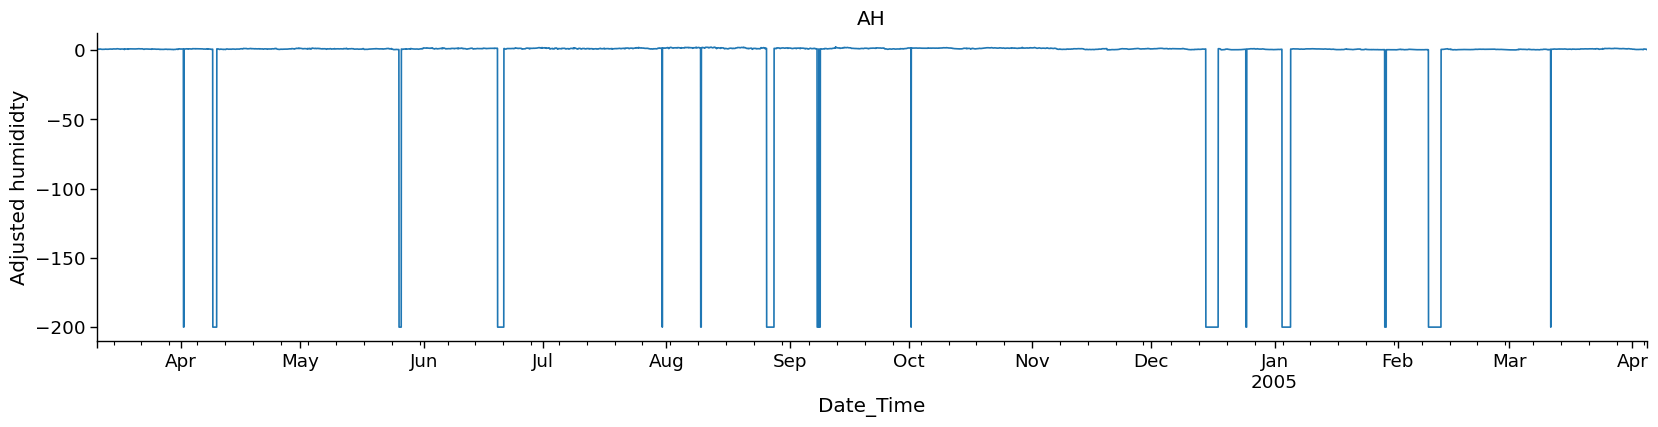

In [4]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.show()

### 1.1) Preprocessing Data

In [5]:
# Reduce the time span
data = data["2004-04-01":"2005-04-30"]
# Resample freq to be hourly. If there are gaps larger than one hour they will be representing as NaNs.
data = data.asfreq("1H")
# Remove measurements from fixed stations. We'll only be using sensor data.
drop_vars = [var for var in data.columns if "_true" in var]
# Remove adjusted humidity.
drop_vars.append("AH")

# Remove variables.
data.drop(labels=drop_vars, axis=1, inplace=True)
# Impute negative values with NaNs
data[data < 0] = np.NaN

data

CO_sensor  NMHC_sensor  NOX_sensor  NO2_sensor  \
Date_Time                                                             
2004-04-01 00:00:00 1,143.0000     825.0000    986.0000  1,477.0000   
2004-04-01 01:00:00 1,044.0000     770.0000  1,031.0000  1,425.0000   
2004-04-01 02:00:00 1,034.0000     716.0000  1,085.0000  1,405.0000   
2004-04-01 03:00:00   956.0000     713.0000  1,099.0000  1,422.0000   
2004-04-01 04:00:00   909.0000     615.0000  1,237.0000  1,322.0000   
...                        ...          ...         ...         ...   
2005-04-04 10:00:00 1,314.0000   1,101.0000    539.0000  1,374.0000   
2005-04-04 11:00:00 1,163.0000   1,027.0000    604.0000  1,264.0000   
2005-04-04 12:00:00 1,142.0000   1,063.0000    603.0000  1,241.0000   
2005-04-04 13:00:00 1,003.0000     961.0000    702.0000  1,041.0000   
2005-04-04 14:00:00 1,071.0000   1,047.0000    654.0000  1,129.0000   

                     O3_sensor       T      RH  
Date_Time                                       
2004-04-01 00:00:00   978.0000 12.0000 61.6000  
2004-04-01 01:00:00   944.0000 11.5000 63.9000  
2004-04-01 02:00:00   891.0000 10.7000 67.2000  
2004-04-01 03:00:00   849.0000  9.0000 73.1000  
2004-04-01 04:00:00   790.0000 10.2000 66.6000  
...                        ...     ...     ...  
2005-04-04 10:00:00 1,729.0000 21.9000 29.3000  
2005-04-04 11:00:00 1,269.0000 24.3000 23.7000  
2005-04-04 12:00:00 1,092.0000 26.9000 18.3000  
2005-04-04 13:00:00   770.0000 28.3000 13.5000  
2005-04-04 14:00:00   816.0000 28.5000 13.1000  

[8847 rows x 7 columns]

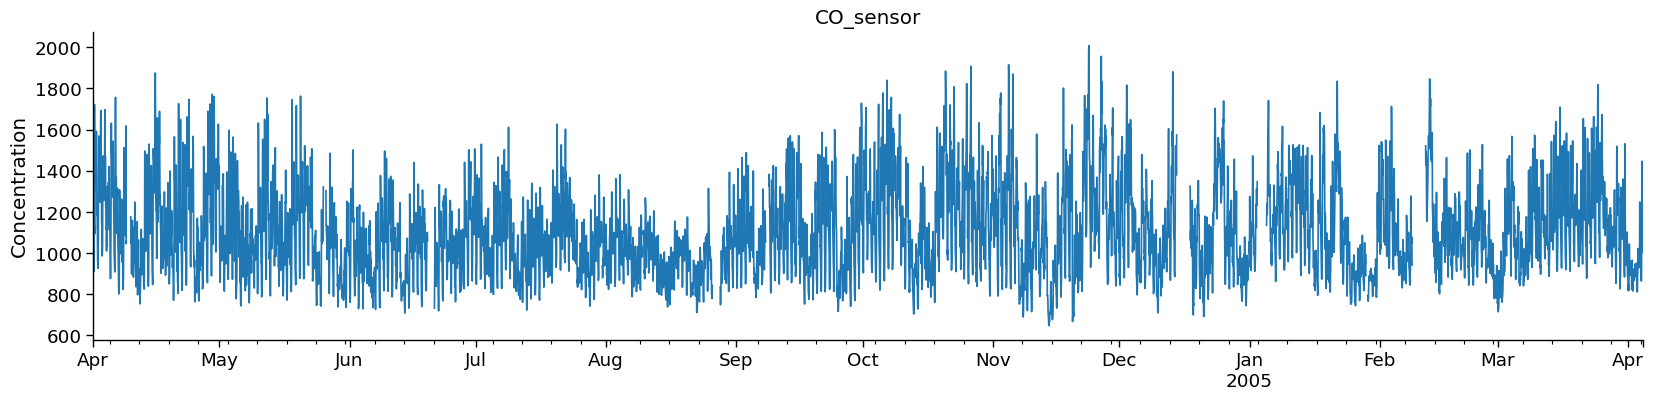

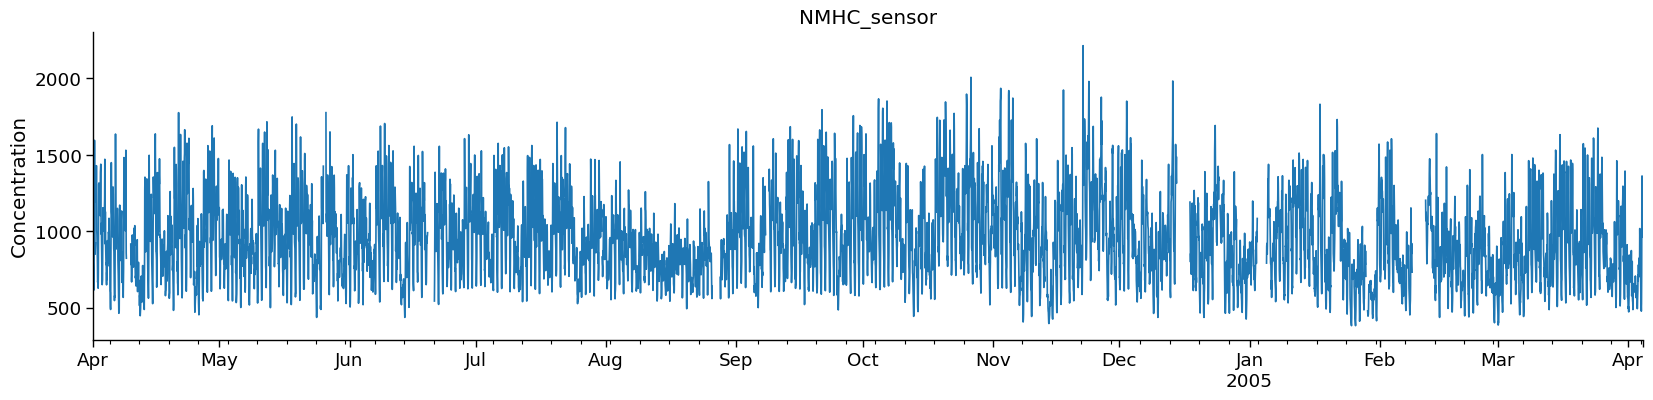

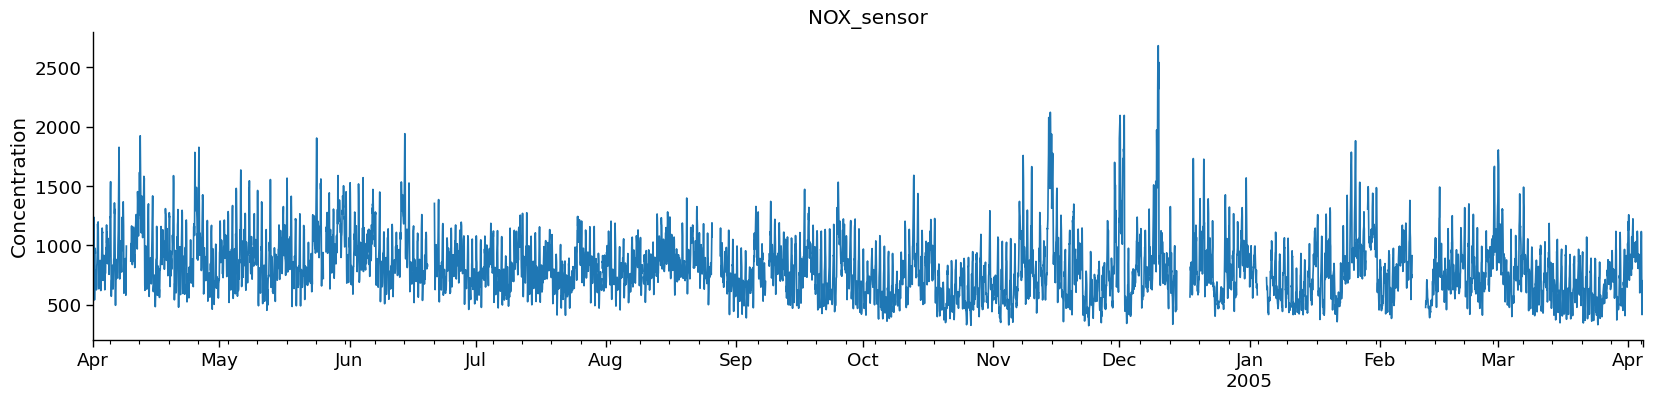

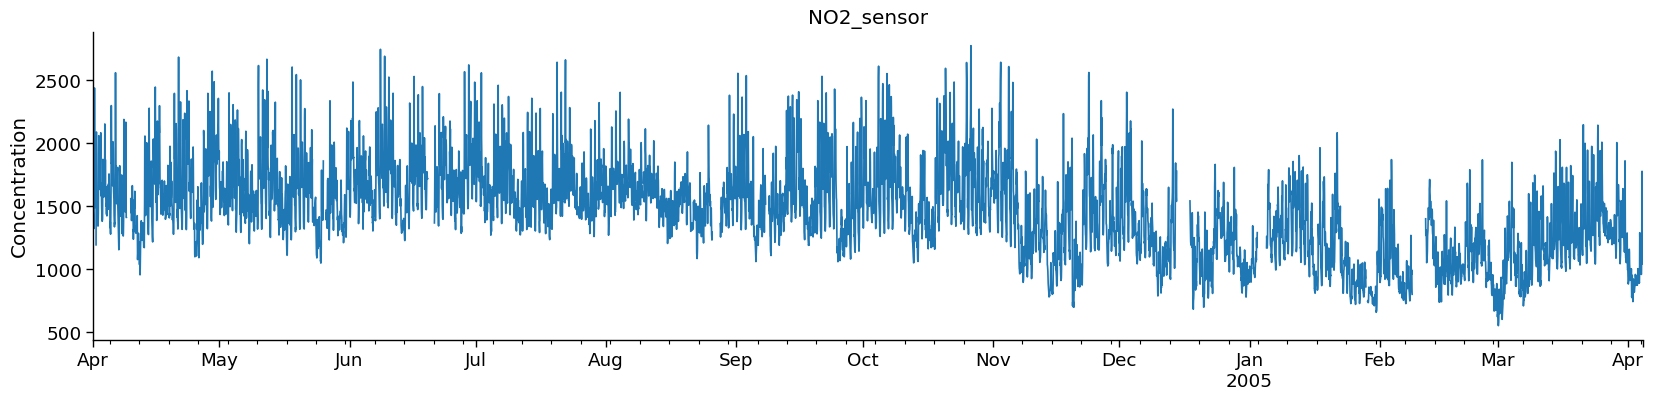

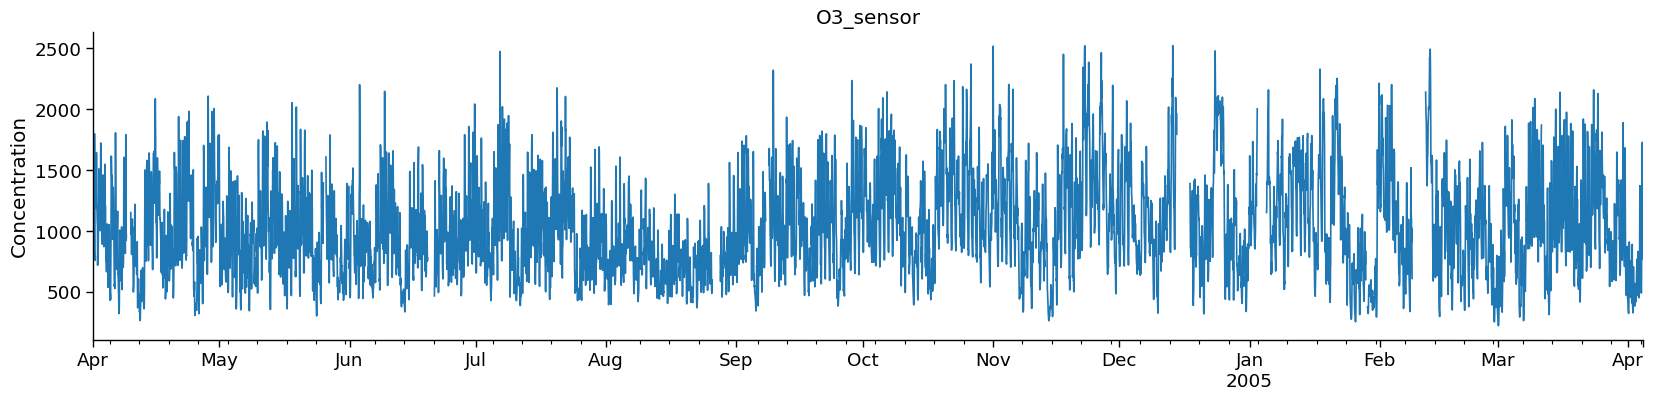

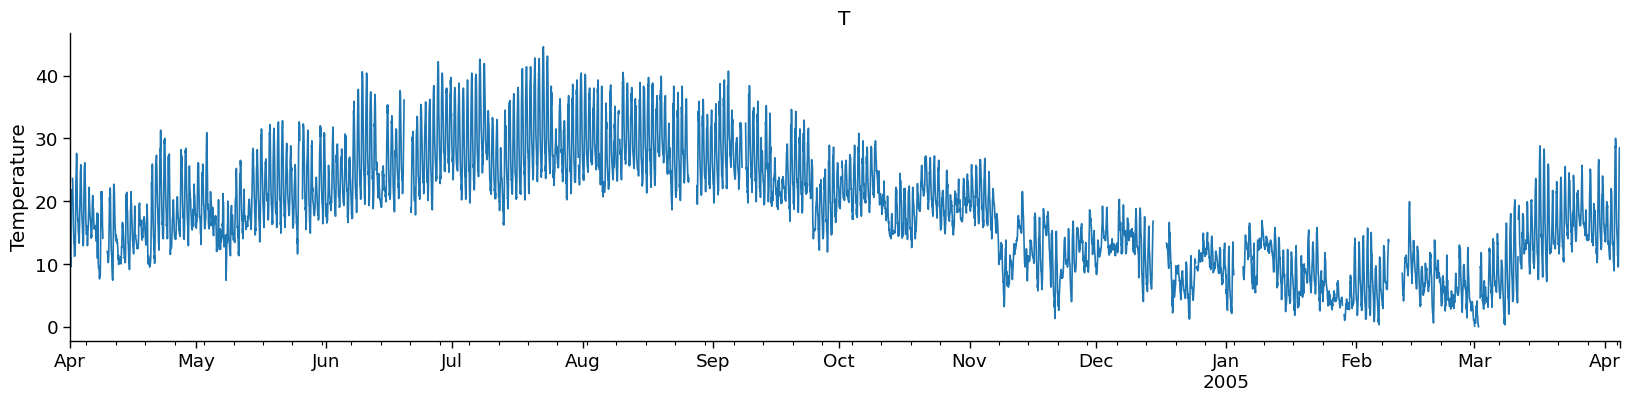

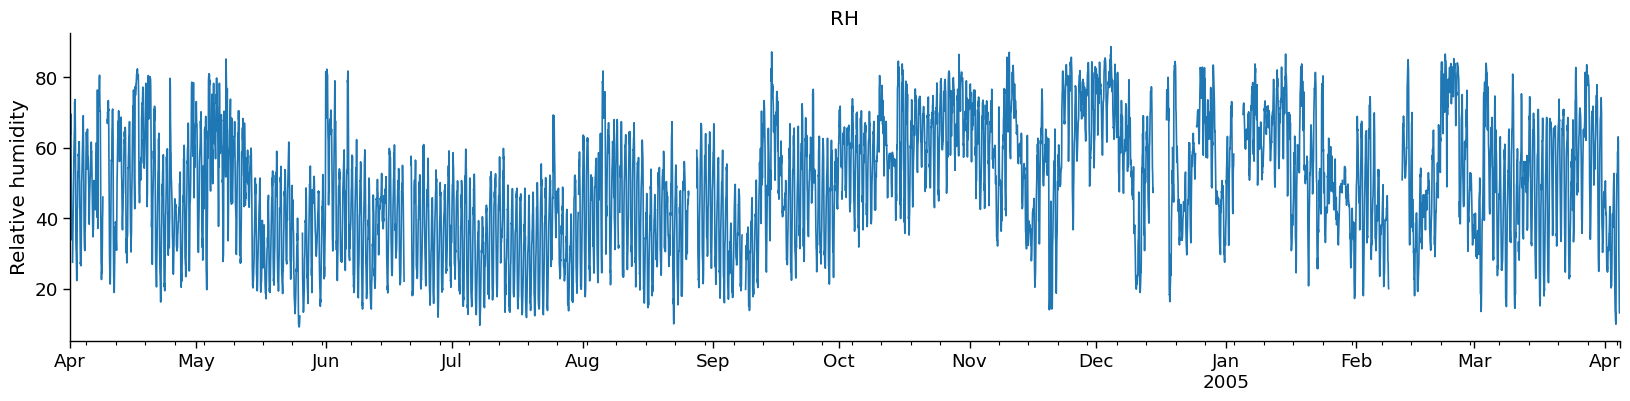

In [7]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.xlabel("")
    plt.show()

## 2) Domain Knowledge
* A small number of recent lags would be reasonable: lag of 1 hour, 2 hour, 3 hour.
* We might expect a daily pattern to air pollution concentration: a lag of 24 hours.
* Likewise we might expect weekends to behave differently to weekdays. Thus, weekly seasonality, a lag of one week (7x24 hours).
* A yearly seasonality, therefore a lag of 1 year (~ 365x24 hours).

In [8]:
# Extract a bunch of date time features to use to check for seasonality
data["date"] = data.index.date
data["time_of_day"] = data.index.hour
data["month"] = data.index.month
data["day_of_week"] = data.index.dayofweek
data["week_of_year"] = data.index.isocalendar().week
data

CO_sensor  NMHC_sensor  NOX_sensor  NO2_sensor  \
Date_Time                                                             
2004-04-01 00:00:00 1,143.0000     825.0000    986.0000  1,477.0000   
2004-04-01 01:00:00 1,044.0000     770.0000  1,031.0000  1,425.0000   
2004-04-01 02:00:00 1,034.0000     716.0000  1,085.0000  1,405.0000   
2004-04-01 03:00:00   956.0000     713.0000  1,099.0000  1,422.0000   
2004-04-01 04:00:00   909.0000     615.0000  1,237.0000  1,322.0000   
...                        ...          ...         ...         ...   
2005-04-04 10:00:00 1,314.0000   1,101.0000    539.0000  1,374.0000   
2005-04-04 11:00:00 1,163.0000   1,027.0000    604.0000  1,264.0000   
2005-04-04 12:00:00 1,142.0000   1,063.0000    603.0000  1,241.0000   
2005-04-04 13:00:00 1,003.0000     961.0000    702.0000  1,041.0000   
2005-04-04 14:00:00 1,071.0000   1,047.0000    654.0000  1,129.0000   

                     O3_sensor       T      RH        date  time_of_day  \
Date_Time                                                                 
2004-04-01 00:00:00   978.0000 12.0000 61.6000  2004-04-01            0   
2004-04-01 01:00:00   944.0000 11.5000 63.9000  2004-04-01            1   
2004-04-01 02:00:00   891.0000 10.7000 67.2000  2004-04-01            2   
2004-04-01 03:00:00   849.0000  9.0000 73.1000  2004-04-01            3   
2004-04-01 04:00:00   790.0000 10.2000 66.6000  2004-04-01            4   
...                        ...     ...     ...         ...          ...   
2005-04-04 10:00:00 1,729.0000 21.9000 29.3000  2005-04-04           10   
2005-04-04 11:00:00 1,269.0000 24.3000 23.7000  2005-04-04           11   
2005-04-04 12:00:00 1,092.0000 26.9000 18.3000  2005-04-04           12   
2005-04-04 13:00:00   770.0000 28.3000 13.5000  2005-04-04           13   
2005-04-04 14:00:00   816.0000 28.5000 13.1000  2005-04-04           14   

                     month  day_of_week  week_of_year  
Date_Time                                              
2004-04-01 00:00:00      4            3            14  
2004-04-01 01:00:00      4            3            14  
2004-04-01 02:00:00      4            3            14  
2004-04-01 03:00:00      4            3            14  
2004-04-01 04:00:00      4            3            14  
...                    ...          ...           ...  
2005-04-04 10:00:00      4            0            14  
2005-04-04 11:00:00      4            0            14  
2005-04-04 12:00:00      4            0            14  
2005-04-04 13:00:00      4            0            14  
2005-04-04 14:00:00      4            0            14  

[8847 rows x 12 columns]

### 2.1) Daily seasonality

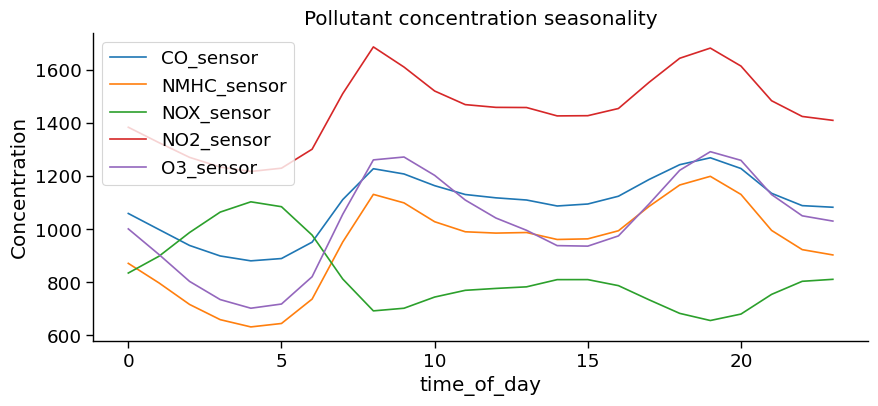

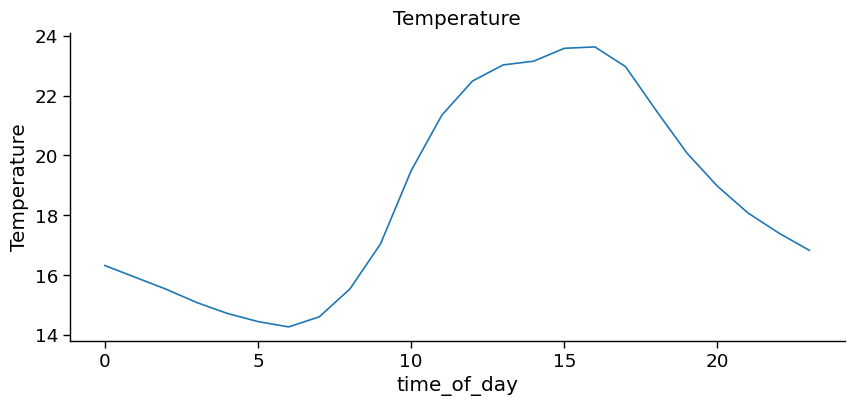

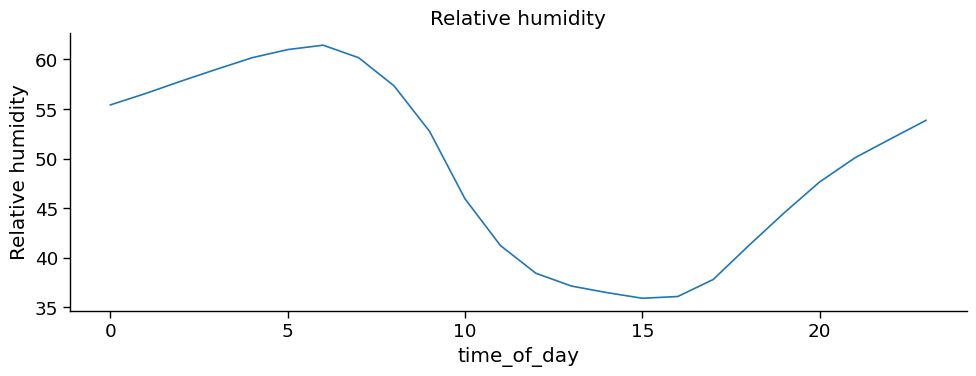

In [13]:
sensor_cols = [col for col in data.columns if "sensor" in col]
fig, ax = plt.subplots(figsize=(10, 4))
data.groupby("time_of_day")[sensor_cols].mean().plot(ax=ax)
plt.title("Pollutant concentration seasonality")
plt.ylabel("Concentration")

fig, ax = plt.subplots(figsize=(10, 4))
data.groupby("time_of_day")["T"].mean().plot(ax=ax)
plt.title("Temperature")
plt.ylabel("Temperature")

fig, ax = plt.subplots(figsize=(10, 4))
data.groupby("time_of_day")["RH"].mean().plot(ax=ax)
plt.title("Relative humidity")
plt.ylabel("Relative humidity")

plt.tight_layout()

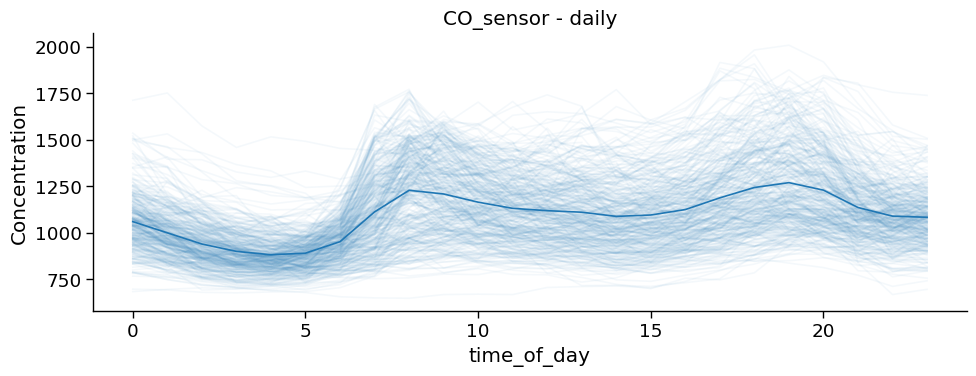

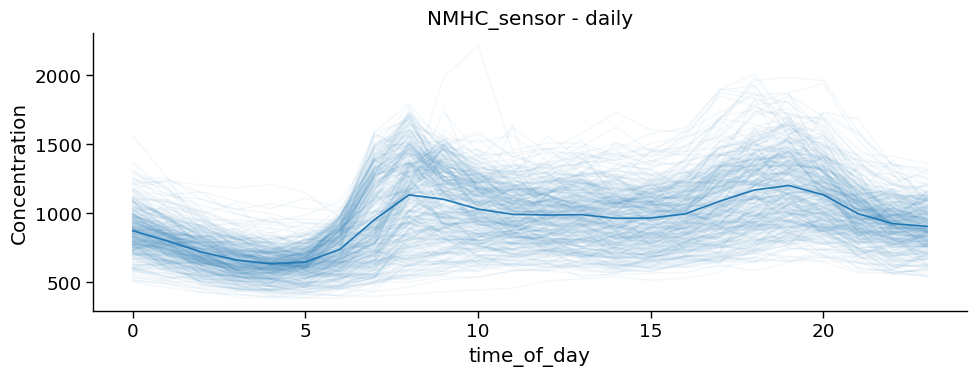

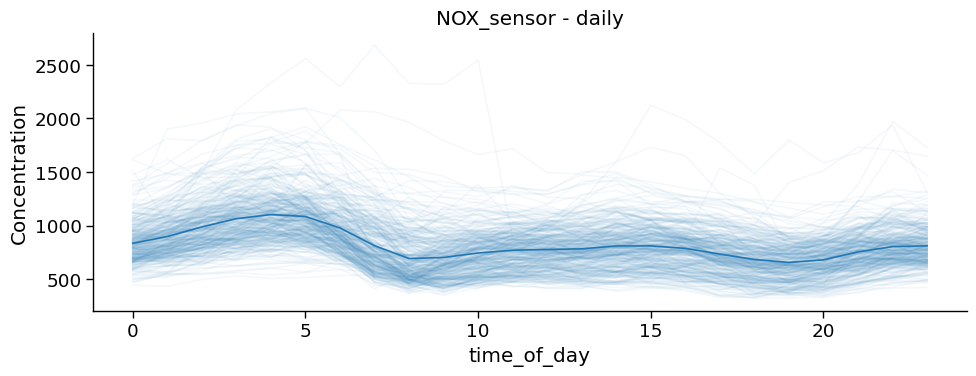

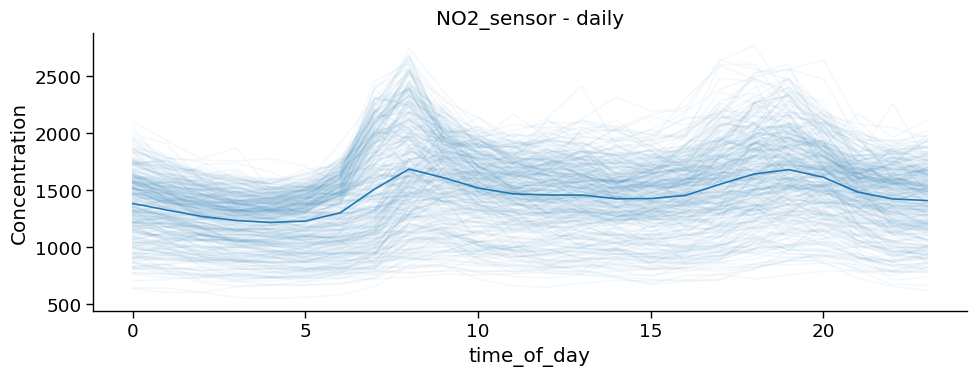

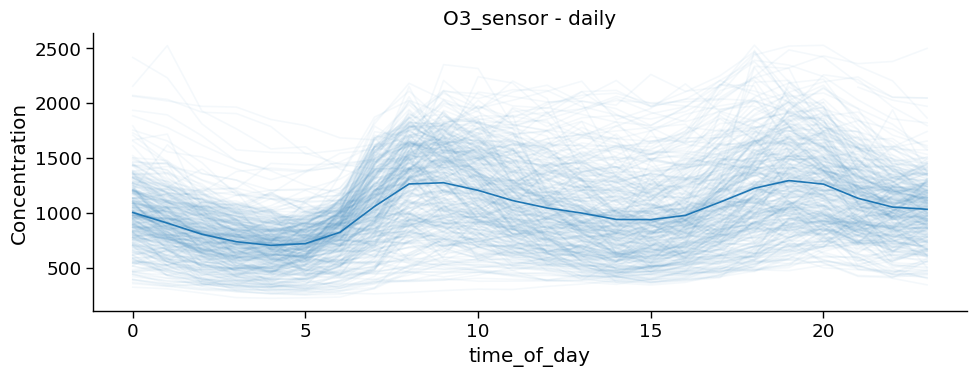

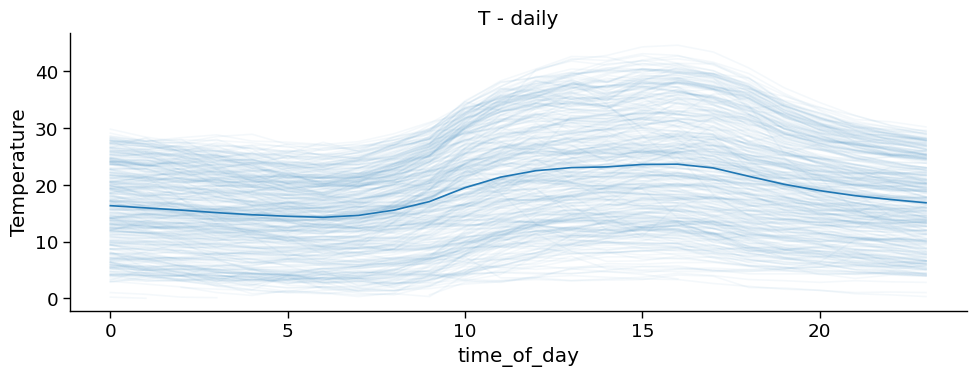

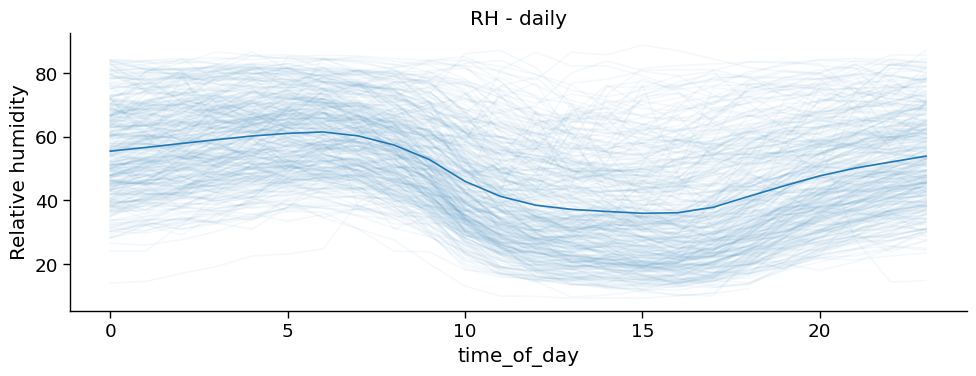

In [16]:
# Let's plot the entire dataset to confirm the daily seasonality
cmap = sns.color_palette("Blues", n_colors=5)
variables = [
    "CO_sensor",
    "NMHC_sensor",
    "NOX_sensor",
    "NO2_sensor",
    "O3_sensor",
    "T",
    "RH",
]

for var in variables:
    fig, ax = plt.subplots(figsize=[10, 4])
    (
        data.pivot(index=["time_of_day"], columns=["date"])[var].plot(
            legend=False, alpha=0.05, color=cmap[3], ax=ax
        )
    )
    (data.groupby("time_of_day").mean(numeric_only=True)[var].plot(ax=ax))
    ax.set_title(f"{var} - daily")
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.tight_layout()

We observe a clear daily pattern amongst all the concentrations, the temperature, and the relative humidity. This is enough to suggest a lag of 24 hours.

### 2.2) Weekly seasonality

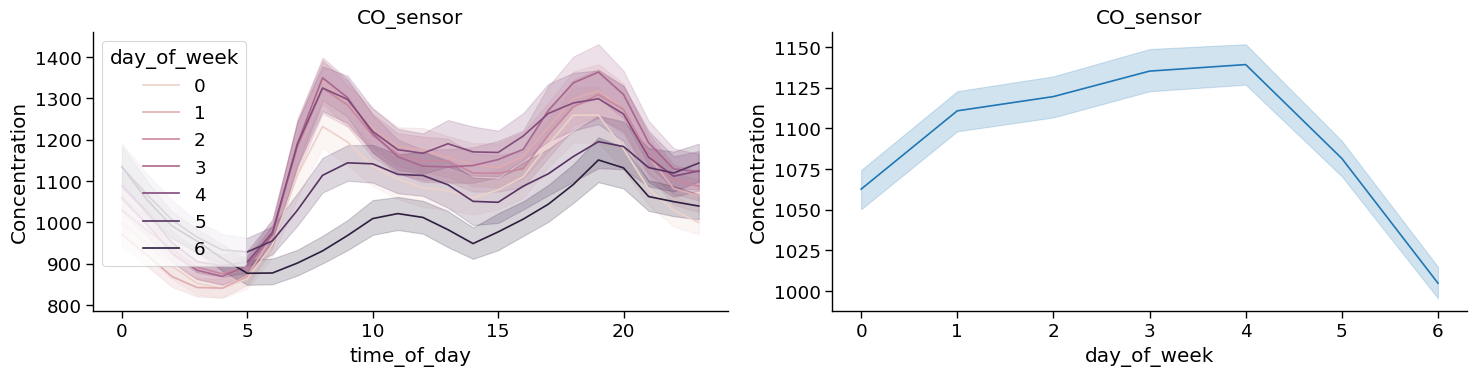

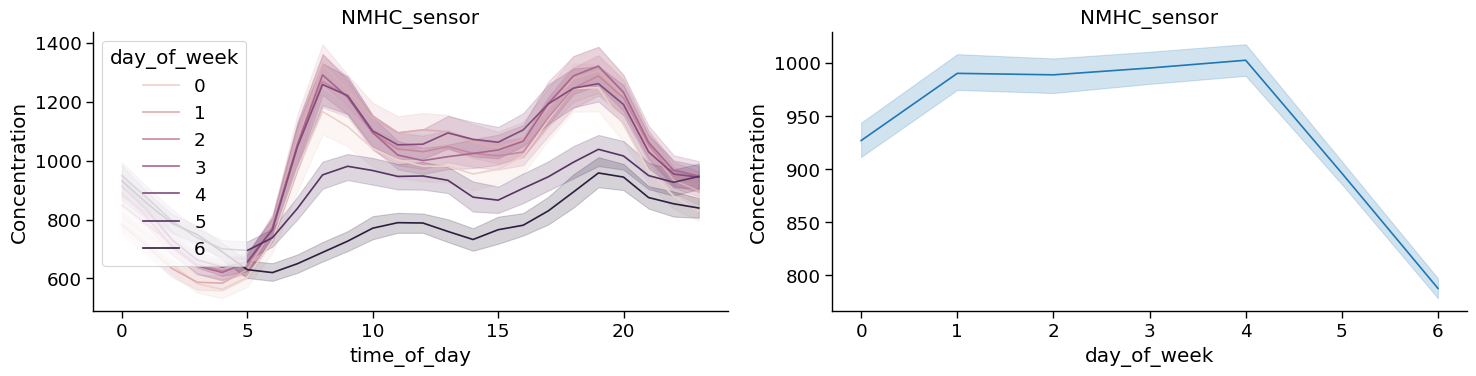

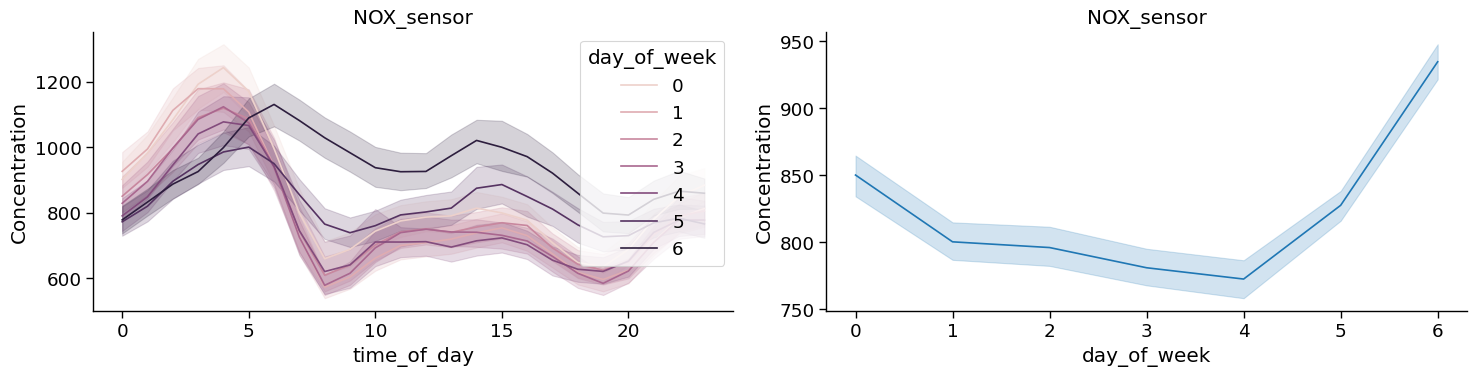

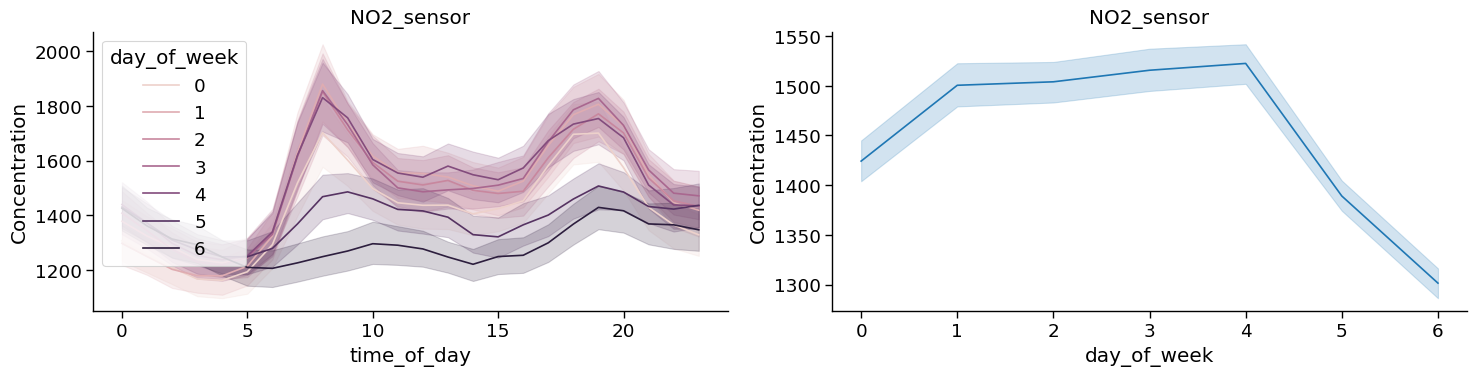

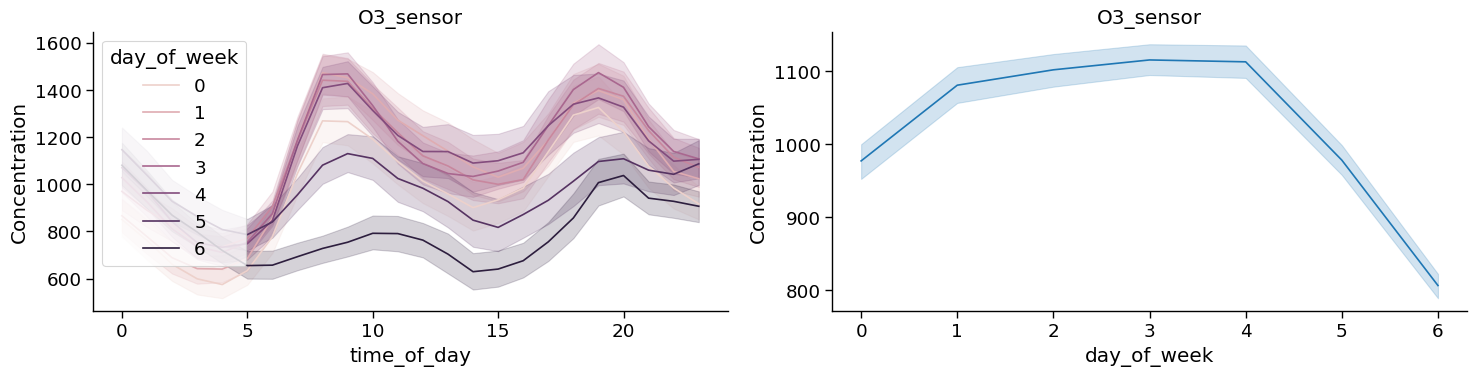

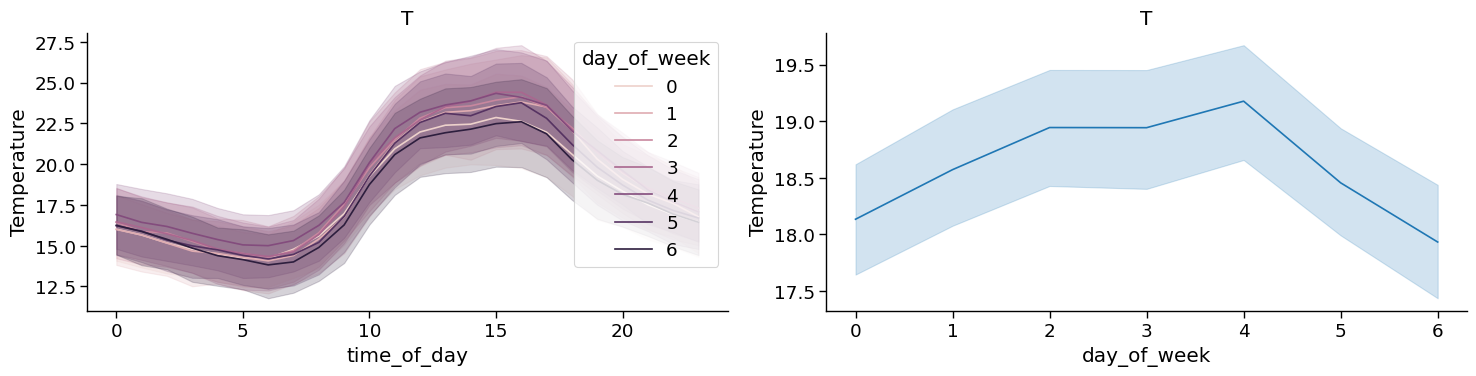

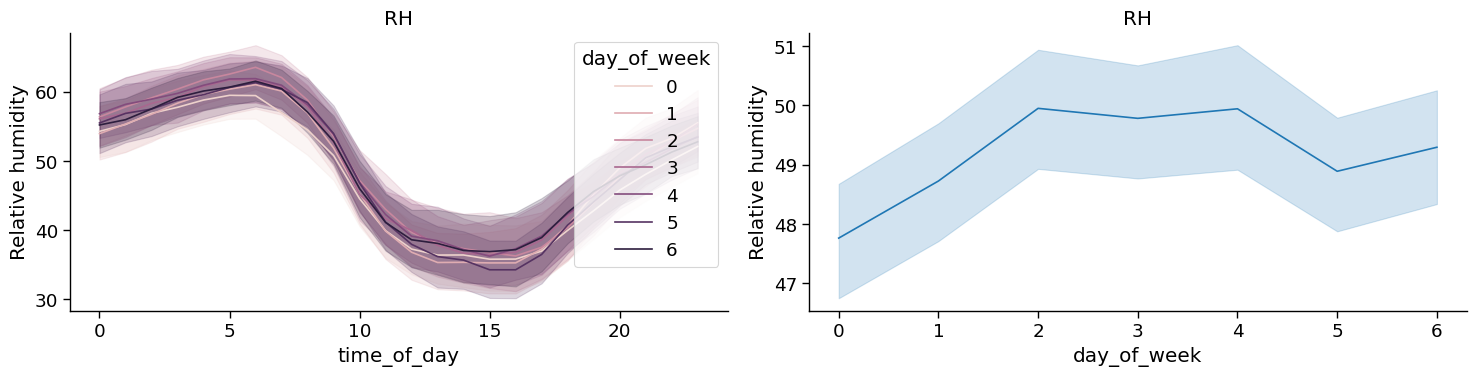

In [18]:
pd.plotting.register_matplotlib_converters()

for var in variables:
    fig, ax = plt.subplots(ncols=2, figsize=[15, 4])
    ylabel = col_by_ylabel.get(var)
    sns.lineplot(data=data, y=var, x="time_of_day", hue="day_of_week", ax=ax[0])
    if ylabel:
        ax[0].set_ylabel(ylabel)
    else:
        ax[0].set_ylabel("Concentration")
    ax[0].set_title(var)
    sns.lineplot(x="day_of_week", y=var, data=data, ax=ax[1])
    if ylabel:
        ax[1].set_ylabel(ylabel)
    else:
        ax[1].set_ylabel("Concentration")
    ax[1].set_title(var)
    plt.tight_layout()

### 2.3) Yearly seasonality

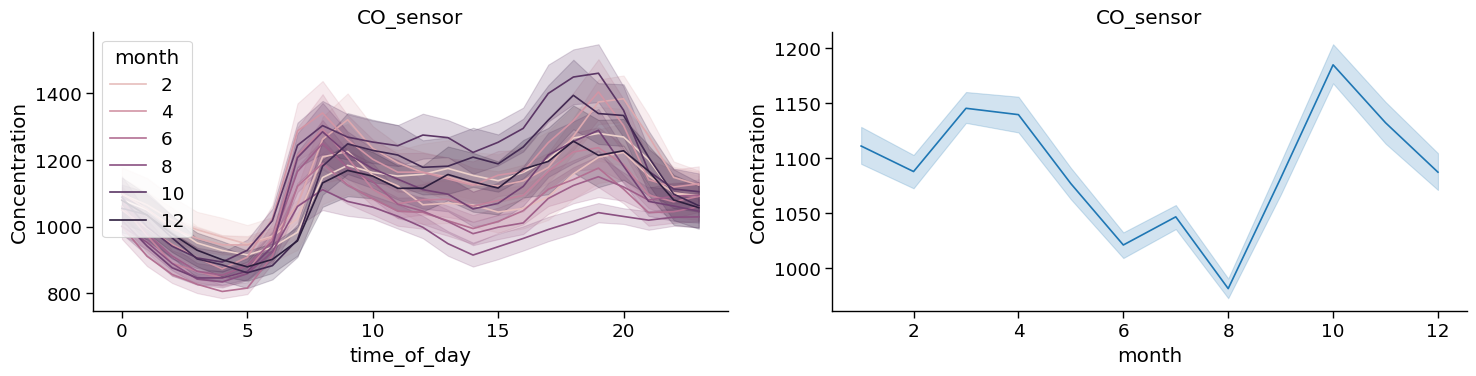

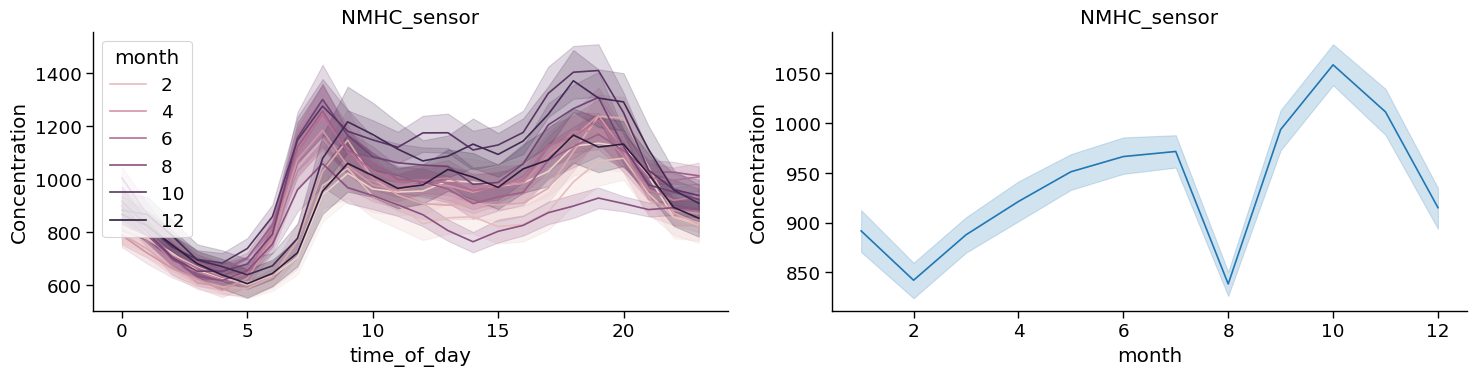

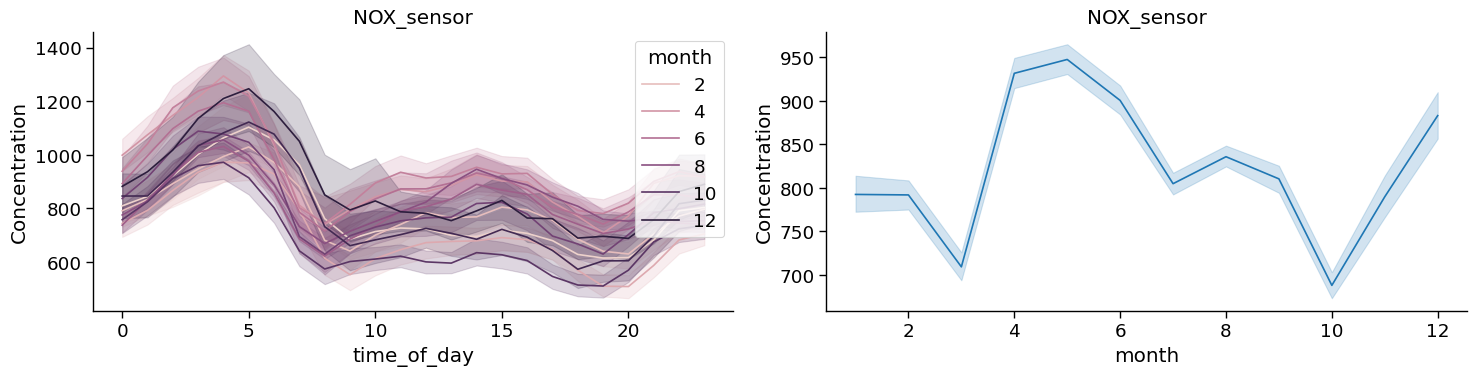

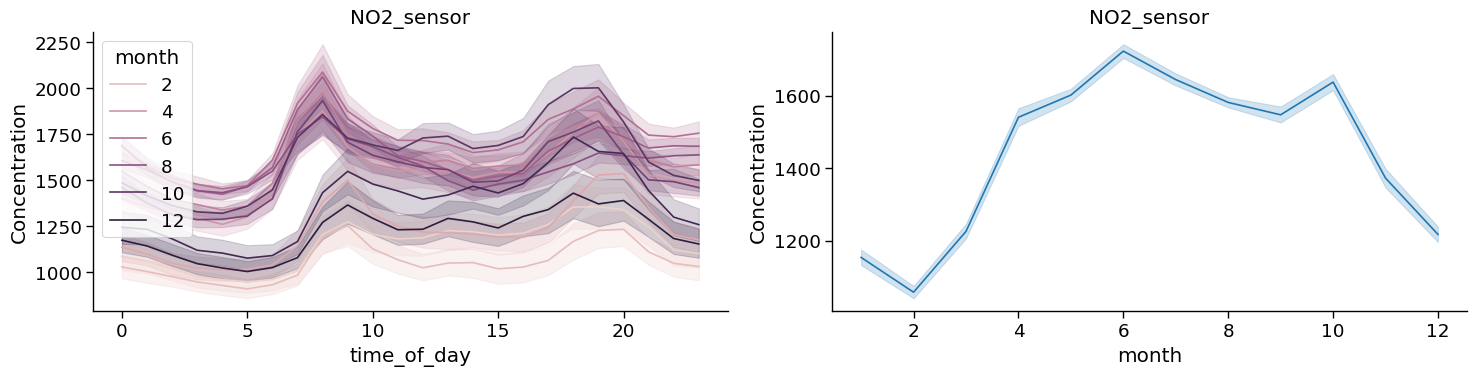

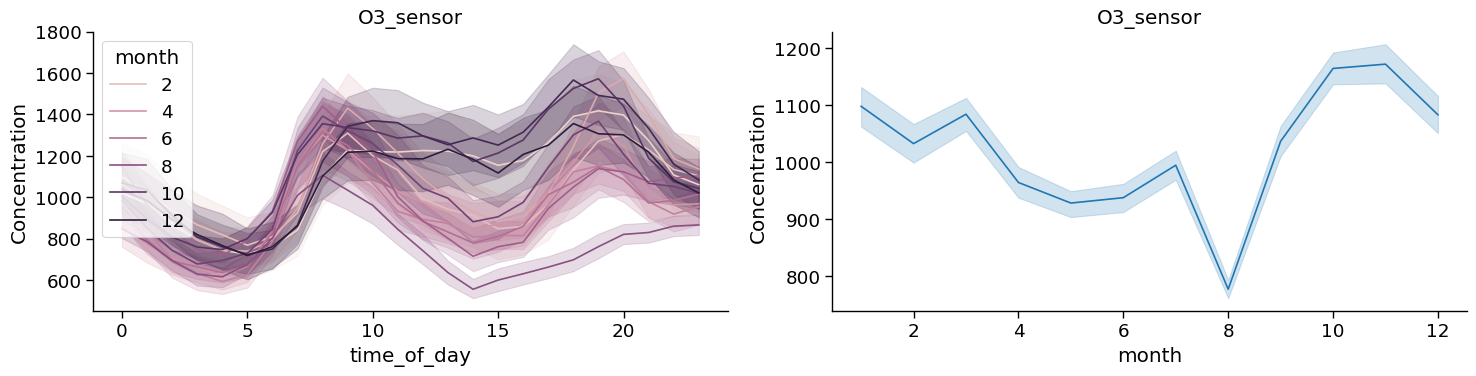

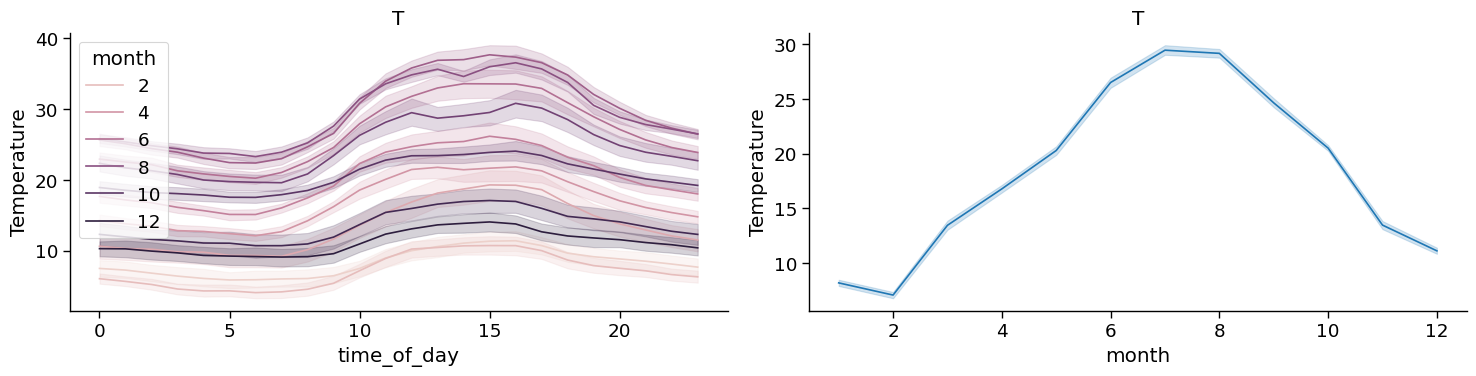

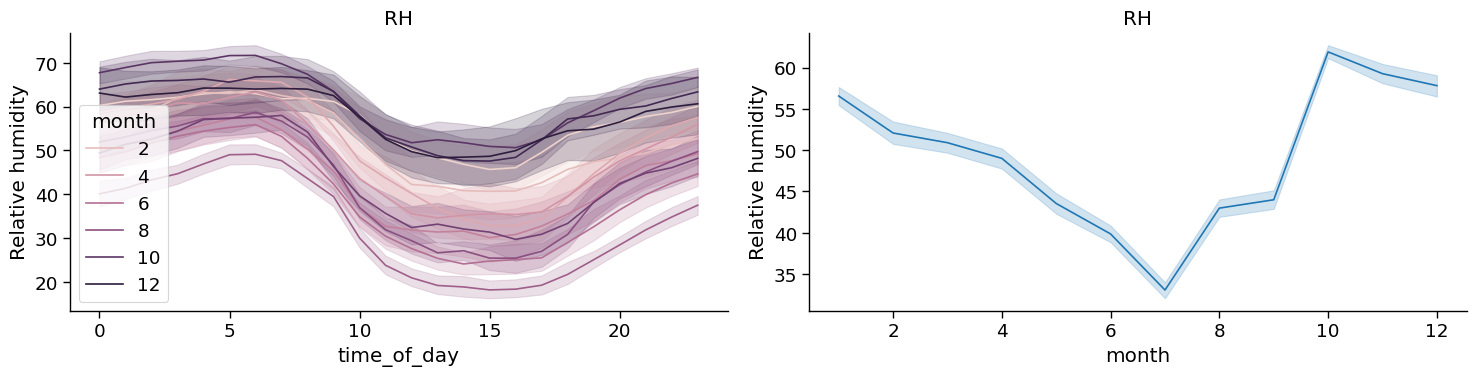

In [19]:
for var in variables:
    fig, ax = plt.subplots(ncols=2, figsize=[15, 4])
    ylabel = col_by_ylabel.get(var)
    sns.lineplot(data=data, y=var, x="time_of_day", hue="month", ax=ax[0])
    if ylabel:
        ax[0].set_ylabel(ylabel)
    else:
        ax[0].set_ylabel("Concentration")
    ax[0].set_title(var)
    sns.lineplot(x="month", y=var, data=data, ax=ax[1])
    if ylabel:
        ax[1].set_ylabel(ylabel)
    else:
        ax[1].set_ylabel("Concentration")
    ax[1].set_title(var)
    plt.tight_layout()

## Conclusions
We could try the following lags:
* **Recent lags**:  1 hour, 2 hours, and 3 hours.
* **Seasonal lags**: daily (24 hours), weekly ( 7x24 hours), and yearly (24x365 hours) seasonalities.